In [ ]:
import pickle

with open('trained_model.pickle', 'rb') as f:
    model = pickle.load(f)
    
    with open('count_vect.pickle', 'rb') as g:
        vect = pickle.load(g)
        predict = model.predict(vect)
        print(predict)



In [ ]:
k = ['indihome terbaik', 'saya cinta indihome', 'saya', 'benci', 'indihome']
l = []
for x in k:
    l = l+x.split()

m = collections.Counter(l)
m.most_common()

In [ ]:
import collections

def class_frequency(class_feats):
    counter = collections.Counter(class_feats)
    cc = []
    for x in counter.most_common():
        cc.append(x)
    return cc

x = ['negatif', 'negatif', 'positif', 'negatif', 'positif']
y = class_frequency(x)
aaa, bbb = [a for a, b in y], [b for a, b in y]
if aaa[0]=='negatif':
    print('neg')
    print(aaa[0], bbb[0])
    print(bbb[1])
if aaa[0]=='positif':
    print('pos')
    print(aaa[0], bbb[0])
    print(bbb[1])

In [ ]:
import matplotlib.pyplot as plt 

plt.clf()

plt.figure(figsize=(9,5))

x = ['negatif', 'positif']
y = [172, 153]

plt.subplot()
plt.title('Histogram Sentimen', loc='center', pad=30, fontsize=15)
plt.xlabel('Sentimen', fontsize=15)
plt.ylabel('Jumlah Tweet', fontsize=15)
plt.bar(x, y, color=['red', 'green'])
plt.tight_layout()


made status.csv


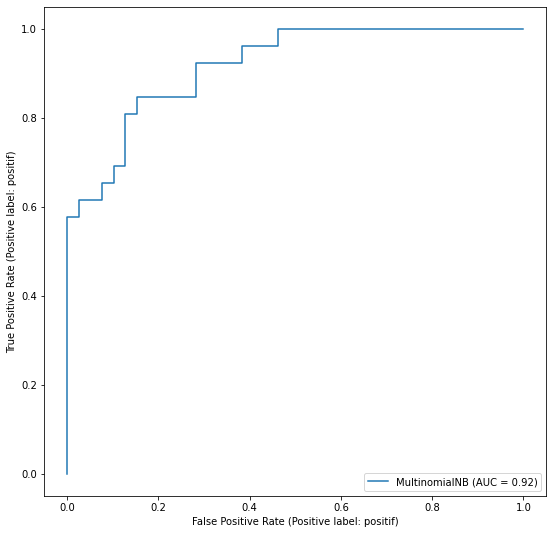

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
import pickle, csv
from preprocessing import Preprocessing
import matplotlib.pyplot as plt


tweet = []
label = []
with open('data/unggahan/training_data.csv', 'r', encoding='utf8') as file_csv:
    reader = csv.DictReader(file_csv)
    for row in reader:
        tweet.append(row["text"])               # ambil teks tweet
        label.append(row["sentiment"])          # ambil label sentimen

preprocessing = Preprocessing()
case_folding = preprocessing.case_folding(tweet)
stop_word_removal = preprocessing.stop_word_removal(case_folding)
vect = CountVectorizer(binary=True)
tokenized = vect.fit_transform(stop_word_removal)

x_train, x_test, label_train, label_test = train_test_split(tokenized, label, test_size=0.2, random_state=1)
model = MultinomialNB(alpha=1)              # Multinomial Naive Bayes dengan Laplace Smoothing
model.fit(x_train, label_train)

fig, ax = plt.subplots(figsize=(9, 9))
plot_roc_curve(model, x_test, label_test, ax=ax)
plt.show() 

In [ ]:
temp = {}
with open('data/latih/status.csv', 'r') as f:
    reader = csv.reader(f)
    for x in reader:
        for y in range(len(x)):
            temp['overall'] = x[0]
            temp['casefolding'] = x[1]
            temp['filtering'] = x[2]
            temp['stemming'] = x[3]
            temp['totalstemmed'] = x[4]
            temp['tokenizing'] = x[5]
            temp['accuracy'] = x[6]
            temp['negatif'] = x[7]
            temp['positif'] = x[8]
print(temp)

In [ ]:
def classify_model(self):
    tweet = []
    label = []
    tweet_id = []
    tweet_date = []

    with open('data/unggahan/training_data.csv', 'r', encoding='utf8') as file_csv:
        reader = csv.DictReader(file_csv)
        for row in reader:
            tweet.append(row["text"])               # ambil teks tweet
            label.append(row["sentiment"])          # ambil label sentimen
            tweet_id.append(row["id"])
            tweet_date.append(row["created_at"])
    
    preprocessing = Preprocessing()         # init
    preprocessing.update_status(0, 1)
    case_folding = preprocessing.case_folding(tweet)
    stop_word_removal = preprocessing.stop_word_removal(case_folding) # filtering
    stemming = preprocessing.stemming(stop_word_removal)

    class_counter = preprocessing.class_frequency(label)
    _class, _counter = [x for x,y in class_counter], [y for x,y in class_counter]
    if _class[0] == 'negatif':
        preprocessing.update_status(7, _counter[0])
        preprocessing.update_status(8, _counter[1])
    if _class[0] == 'positif':
        preprocessing.update_status(7, _counter[1])
        preprocessing.update_status(8, _counter[0])

    vect = CountVectorizer(binary=True)     # tokenizing
    tokenized = vect.fit_transform(stemming)
    preprocessing.update_status(5, 1)
    preprocessing.update_status(0, 2)

    # bagi data dengan perbandingan 8:2
    x_train, x_test, label_train, label_test = train_test_split(tokenized, label, test_size=0.2, random_state=1)
    
    # latih model
    model = MultinomialNB(alpha=1)              # Multinomial Naive Bayes dengan Laplace Smoothing
    model.fit(x_train, label_train)
    predict = model.predict(x_test)
    acc = metrics.accuracy_score(label_test, predict)
    all_predict = model.predict(tokenized)
    preprocessing.update_status(6, acc)
    print(f"Akurasi: {acc}")

    # simpan model
    with open(f"data/latih/trained_model.pickle", 'wb') as pickl:
        pickle.dump(model, pickl)

    # simpan vectorizer
    with open('data/latih/count_vect.pickle', 'wb') as pickl:
        pickle.dump(tokenized, pickl)

    # simpan tweets hasil prediksi
    with open(f'data/latih/tested_data.csv', 'w', newline='\n', encoding='utf8') as tested:
        kolom = ["id", "created_at", "text", "manual_sentiment", "stemmed_text", "predicted_sentiment"]
        writer = csv.DictWriter(tested, fieldnames=kolom)
        writer.writeheader()

        for x in range(len(tweet)):
            text = re.sub('\n', '', tweet[x])
            writer.writerow({
                'id': tweet_id[x],
                'created_at': tweet_date[x],
                'text': text,
                'manual_sentiment': label[x],
                'stemmed_text': stemming[x],
                'predicted_sentiment': all_predict[x]
            })

    # simpan histogram sentimen
    plt.clf()
    plt.figure(figsize=(9,5))
    plt.subplot()
    plt.xlabel('Sentimen', fontsize=15)
    plt.ylabel('Jumlah Tweet', fontsize=15)
    plt.bar(_class, _counter, color=['red', 'green'])
    plt.tight_layout()

    plt.savefig('static/histogram.png')

    # simpan kurva roc
    plt.clf()
    fig, ax = plt.subplots(figsize=(9, 5))
    plot_roc_curve(model, x_test, label_test, ax=ax)
    plt.savefig('static/roc_curve.png')

<Figure size 432x288 with 0 Axes>

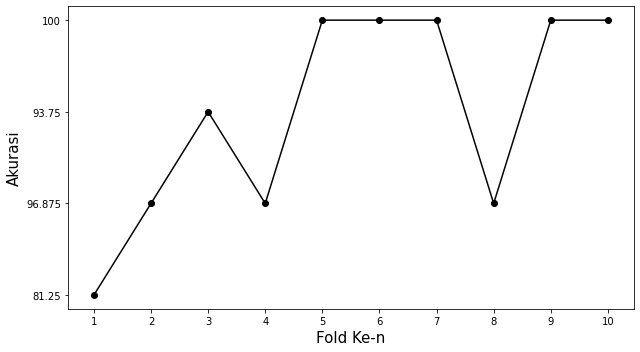

In [27]:
import matplotlib.pyplot as plt
import csv, random


acc = []
num = [x+1 for x in range(10)]
with open("data/latih/kfold_acc.csv", 'r') as n:
    reader = csv.reader(n)
    for x in reader:
        for y in x:
            acc.append(y)
plt.clf()
plt.figure(figsize=(9,5))
plt.plot(num, acc, '-o', color="black")
plt.xlabel('Fold Ke-n', fontsize=15)
plt.ylabel('Akurasi', fontsize=15)
plt.xticks(num)
plt.tight_layout()


In [ ]:

def manual_word_frequency(self, teks):
    words = []
    for x in teks:
        words = words + x.split()
    counter = collections.Counter(words)
    return counter.most_common()

In [45]:
# K_FOLD CROSS_VALIDATION
import copy

data = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

folds = 2
index = int(len(data) / folds)

# split data into multiple folds
f = []
for x in range(folds):
    g = []
    while len(g) < index:
        g.append(data.pop(0))
    f.append(g)

# train_test_split, kinda...
y = 0
for x in range(folds):
    while y < folds:
        print(f"fold-{y}:")
        data_copy = copy.deepcopy(f)
        print(data_copy.pop(y))
        print(data_copy)
        print()
        # TO-BE IMPLEMENTED: naive bayes predictor
        y += 1




fold-0:
['a', 'b', 'c', 'd', 'e']
[['f', 'g', 'h', 'i', 'j']]

fold-1:
['f', 'g', 'h', 'i', 'j']
[['a', 'b', 'c', 'd', 'e']]



In [32]:
import csv, re
from collections import Counter

def tokenize(text):
    return [x.split() for x in text]

def cfold(text):
    cf = []
    for x in text:
        r1 = re.sub('\@[A-Za-z0-9._]+|(^rt)|(http|https)://[A-Za-z0-9.\-\/]+|\#\w+', '', x.lower())
        r4 = re.sub('\W|\n+', ' ', r1)      # hapus tanda baca, emoji, dan newline char
        r5 = re.sub('\s{2,}', ' ', r4)      # hapus spasi lebih dari 1
        r6 = re.sub('^\s|\s$', '', r5)      # hapus spasi di awal dan akhir kalimat
        cf.append(r6)
    return cf

def training(word_dict):
    freq = {}
    _sent = []

    # HITUNG FREKUENSI KATA PADA KELAS POSITIF DAN NEGATIF DARI DATA LATIH
    for text, sent in word_dict:
        _sent.append(sent)
        for x in text:
            if x not in freq:
                freq[x] = {'positif':0, 'negatif':0}
            freq[x][sent] += 1
            ### freq = {'kata': {'positif':x, 'negatif':x}, 'kata': {'positif':x, 'negatif':x}, dst}
    
    # HITUNG JUMLAH KATA PADA KELAS POSITIF DAN NEGATIF
    vocab = positif = negatif = 0
    for k,v in freq.items():
        if k: vocab += 1
        positif += v['positif']
        negatif += v['negatif']
    jml = positif + negatif
    pos = positif/jml
    neg = negatif/jml

    # HITUNG PROBABILITAS PRIOR
    _pos, _neg = prior(_sent)
    print(f"prior pos: {_pos}, prior neg: {_neg}")

    return[pos, neg]

def prior(sent):
    cc = Counter(sent)
    pos = cc['positif'] / (cc['positif'] + cc['negatif'])
    neg = cc['negatif'] / (cc['positif'] + cc['negatif'])
    return pos, neg

temp = []
sent = []
with open('data/indihome_tweets.csv', 'r', encoding="utf8") as f:
    reader = csv.DictReader(f)
    for x in reader:
        temp.append(x['text'])
        sent.append(x['sentiment'])
z = cfold(temp)
c = tokenize(z)
zipped = zip(c, sent)

pp = training(zipped)
print(pp)



prior pos: 0.4707692307692308, prior neg: 0.5292307692307693
jumlah positif: 1678, jumlah negatif: 1991, jumlah semua: 3669, vocabulary: 1223


AttributeError: 'NoneType' object has no attribute 'pos'

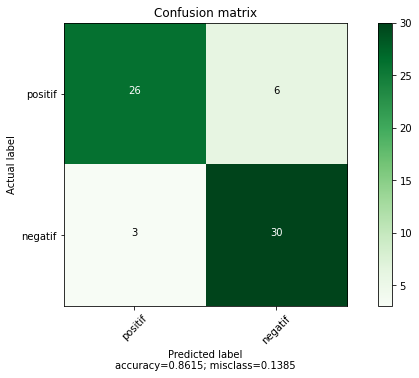

In [3]:
def plot_confusion_matrix(cmx,
                          target_names,
                          title='Confusion matrix',
                          cmap=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    cm = np.array(cmx)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    plt.tight_layout()
    plt.savefig('static/conf_matrix.png')

cm = [[26, 6],[3, 30]]
target = ['positif', 'negatif']
plot_confusion_matrix(cm, target_names=target, cmap="Greens")